In [176]:
from scipy.stats import gamma, lognorm
import pandas as pd
import numpy as np

import matplotlib.pylab as plt
import seaborn as sns

from pyscripts.test_utils import toy_schedule
from pyscripts.planner import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load, check, clean, clusterize the edges

- **load**, rename columns and use unique index

In [182]:
schedule_raw = pd.read_pickle("data/schedule_raw.pkl")
schedule_raw.head()

,arr_day,arr_node,arr_time,delays,delta,dep_day,dep_node,dep_time,mean_delay,std_delay,trip_id
0,0,Stettbach,0 days 23:17:00,"(-2, 341, 194, 346, -71, 70, -5, 41, 3, 1, -20...",NaN,0,Dietlikon,0 days 23:14:00,60.151515,105.014023,85:11:18388:001
1,0,Zürich Stadelhofen,0 days 23:22:00,"(1, 316, 187, 406, -1, 37, -1, 18, 12, 9, 13, ...",NaN,0,Stettbach,0 days 23:18:00,67.666667,97.935459,85:11:18388:001
2,0,Zürich HB,0 days 23:26:00,"(-45, 221, 125, 354, -46, -25, -40, -39, -38, ...",NaN,0,Zürich Stadelhofen,0 days 23:23:00,14.606061,92.191695,85:11:18388:001
3,0,Zürich Hardbrücke,0 days 23:31:00,"(38, 97, 47, 234, 19, 43, 29, 25, 40, 37, 23, ...",NaN,0,Zürich HB,0 days 23:29:00,40.606061,38.486150,85:11:18388:001
4,0,Zürich Altstetten,0 days 23:35:00,"(-22, 27, 18, 174, -34, 1, -22, -22, -7, 7, -1...",NaN,0,Zürich Hardbrücke,0 days 23:31:00,3.545455,40.070322,85:11:18388:001


In [187]:
schedule_raw[schedule_raw.dep_node == 'Zürich Altstetten, Bahnhof N']

,arr_day,arr_node,arr_time,delays,delta,dep_day,dep_node,dep_time,mean_delay,std_delay,trip_id
542,NaN,Zürich Altstetten,NaN,NaN,NaN,NaN,"Zürich Altstetten, Bahnhof N",NaN,125.151687,0.0,0000
543,NaN,"Zürich Altstetten, Bahnhof",NaN,NaN,NaN,NaN,"Zürich Altstetten, Bahnhof N",NaN,200.019930,0.0,0000
544,NaN,"Zürich, Würzgraben",NaN,NaN,NaN,NaN,"Zürich Altstetten, Bahnhof N",NaN,298.732381,0.0,0000


In [166]:
schedule = pd.read_pickle("data/schedule_raw.pkl")\
    .rename(columns={
        "start": "dep_node", 
        "stop": "arr_node", 
        "departure_time": 
        "dep_time", "arrival_time": 
        "arr_time",
        "day_1": "dep_day",
        "day_2": "arr_day"
    })
schedule.reset_index(drop=True, inplace=True)

# put the walking time in the arrival time
schedule.loc[schedule.trip_id=="0000", "walking_time"] = schedule.loc[schedule.trip_id == "0000", "mean_delay"].apply(lambda secs: pd.Timedelta("00:00:"+str(secs)))

# add column with the number of delays per edge
schedule.loc[~schedule.delays.isnull(), "num_delays"] = schedule.delays.loc[~schedule.delays.isnull()].apply(lambda x: np.NaN if x == np.NaN else len(x))

# sort columns and drop mean_delay and std_delay
schedule = schedule[["trip_id", "dep_node", "arr_node", "dep_day", "arr_day", "dep_time", "arr_time", "delays", "num_delays", "walking_time"]].copy()

schedule.head()

,trip_id,dep_node,arr_node,dep_day,arr_day,dep_time,arr_time,delays,num_delays,walking_time
0,85:11:18388:001,Dietlikon,Stettbach,0,0,23:14:00,23:17:00,"(-2, 62, 257, 194, 233, 75, -20, -8, -5, 34, 4...",33.0,NaT
1,85:11:18388:001,Stettbach,Zürich Stadelhofen,0,0,23:18:00,23:22:00,"(1, 13, 219, 187, 203, 44, 13, 1, 12, 148, 14,...",33.0,NaT
2,85:11:18388:001,Zürich Stadelhofen,Zürich HB,0,0,23:23:00,23:26:00,"(-45, -46, 135, 125, 143, -9, -17, -44, -44, 1...",33.0,NaT
3,85:11:18388:001,Zürich HB,Zürich Hardbrücke,0,0,23:29:00,23:31:00,"(38, 36, 15, 47, 30, 52, 23, 17, 17, 36, 20, 3...",33.0,NaT
4,85:11:18388:001,Zürich Hardbrücke,Zürich Altstetten,0,0,23:31:00,23:35:00,"(-22, -17, 2, 18, -21, 26, -15, -37, -23, -21,...",33.0,NaT


- Drop edges with **few delays**.

Many edges happened **only few times** (we can see it  from the collected number of delays). To build our schedule we drop all the trips that happened **less times than a treshold** because if a trip took place 10 times over 33 weeks then it is reasonable to not consider it in the schedule. Notice that our schedule has been computed **week-wise** because we want to extract a schedule for each day of the week. Therefore, we won't have a different schedule for special days like Easter or Christmas.

In [167]:
# separate bus/metro/train edges from walking edges
no_walk = schedule[(schedule.trip_id != "0000")]
walk = schedule[(schedule.trip_id == "0000")]

# verify how many null values are in the columns
# print("Null values in bus/metro/train edges:\n", no_walk.isnull().sum())
# print("\nNull values in walking edges:\n", walk.isnull().sum())

# check how many delays per bus/metro/train edge we have 
print("Number of delays per bus/metro/train edge:\n", no_walk.num_delays.describe())

Number of delays per bus/metro/train edge:
 count    98409.000000
mean        20.071670
std         11.553257
min          1.000000
25%         12.000000
50%         20.000000
75%         32.000000
max         33.000000
Name: num_delays, dtype: float64


In [168]:
# and keep into the schedule only trips happened more than treshold times
treshold = 20
no_walk = no_walk[no_walk.num_delays >= treshold]
no_walk.head()

,trip_id,dep_node,arr_node,dep_day,arr_day,dep_time,arr_time,delays,num_delays,walking_time
0,85:11:18388:001,Dietlikon,Stettbach,0,0,23:14:00,23:17:00,"(-2, 62, 257, 194, 233, 75, -20, -8, -5, 34, 4...",33.0,NaT
1,85:11:18388:001,Stettbach,Zürich Stadelhofen,0,0,23:18:00,23:22:00,"(1, 13, 219, 187, 203, 44, 13, 1, 12, 148, 14,...",33.0,NaT
2,85:11:18388:001,Zürich Stadelhofen,Zürich HB,0,0,23:23:00,23:26:00,"(-45, -46, 135, 125, 143, -9, -17, -44, -44, 1...",33.0,NaT
3,85:11:18388:001,Zürich HB,Zürich Hardbrücke,0,0,23:29:00,23:31:00,"(38, 36, 15, 47, 30, 52, 23, 17, 17, 36, 20, 3...",33.0,NaT
4,85:11:18388:001,Zürich Hardbrücke,Zürich Altstetten,0,0,23:31:00,23:35:00,"(-22, -17, 2, 18, -21, 26, -15, -37, -23, -21,...",33.0,NaT


In [169]:
# check again the number of delays. The schedule is now half as big and more meaningful
no_walk.num_delays.describe()

count    53100.000000
mean        29.304200
std          5.033482
min         20.000000
25%         28.000000
50%         32.000000
75%         33.000000
max         33.000000
Name: num_delays, dtype: float64

- **Clusterize** all the edges depending on their delays. Edges with similar delays will be associated with the same cluster and each cluster will be associated to a **gamma distribution** initialized with the mean and standart deviation of the delays of the whole cluster. 

We use KMeans to clusterize the edges, however, each edge has between 20 to 33 unordered delays so we extracted the `[20, 30, 40, 50, 60, 70, 80]` qth percentiles for each edge and used them as the features of that edge. This allows to represent more meaningfully the delay distribution of each edge while also dropping some possible outliers.

In [90]:
percentiles = [20, 30, 40, 50, 60, 70, 80]
X = pd.DataFrame(
    columns=percentiles,
)
for p in percentiles:
    X[p] = no_walk.delays.apply(lambda delays: np.percentile(delays, p))
    
X.head()

,20,30,40,50,60,70,80
0,-7.6,-4.4,-2.0,21.0,44.2,72.0,110.6
1,5.0,12.0,13.8,22.0,44.6,59.4,108.8
2,-42.8,-39.4,-37.2,-23.0,-15.4,-2.4,65.2
3,20.4,24.0,29.8,36.0,37.2,41.2,45.8
4,-21.6,-18.2,-16.0,-7.0,3.0,7.4,16.8


Now that we have the features we can run the **KMeans**. Note that the index is the same as the initial dataframe, i.e. we obviously know which percentiles belong to which edge, therefore we can proceed in the clustering. We run KMeans for several number of clusters and plot their respective inertia, i.e. the **within-cluster sum-of-squares**. Then we use the elbow method to choose the more reasonable number of clusters.

Fitting on K=10...
Fitting on K=50...
Fitting on K=100...
Fitting on K=200...
Fitting on K=300...
Fitting on K=500...
Fitting on K=800...


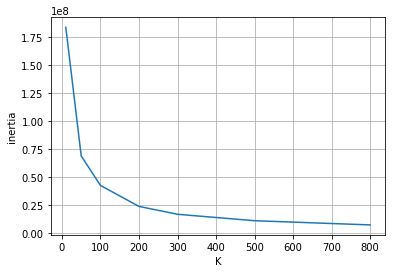

In [209]:
from sklearn.cluster import KMeans

n_clusters = [10, 50, 100, 200, 300, 500, 800]
# n_clusters = np.arange(10, 100, 20)

kmeans = {}
for n_cluster in n_clusters:
    print("Fitting on K="+str(n_cluster) + "...")
    model = KMeans(n_cluster, random_state=0, n_jobs=10)
    kmeans[n_cluster] = model
    
    model.fit(X)

plt.grid()
plt.ylabel("inertia")
plt.xlabel("K")
plt.plot(n_clusters, [model.inertia_ for _, model in kmeans.items()])

In [257]:
# choose the best K and get the corresponding labels
K = 200
X['labels'] = kmeans[K].labels_
X.head()

,20,30,40,50,60,70,80,labels
0,-7.6,-4.4,-2.0,21.0,44.2,72.0,110.6,54
1,5.0,12.0,13.8,22.0,44.6,59.4,108.8,196
2,-42.8,-39.4,-37.2,-23.0,-15.4,-2.4,65.2,190
3,20.4,24.0,29.8,36.0,37.2,41.2,45.8,72
4,-21.6,-18.2,-16.0,-7.0,3.0,7.4,16.8,47


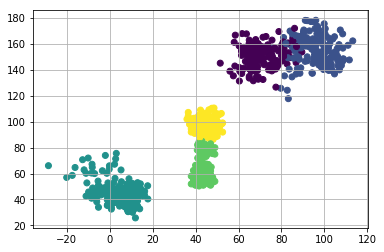

In [260]:
# plot a random subset of the clusters and use only the two percentiles 30 and 70 as dimensions
num_clusters_to_plt = 5
clusters = np.random.choice(K, num_clusters_to_plt, replace=False)
cluster_mapping = dict(zip(clusters, range(num_clusters_to_plt)))

small = X[X['labels'].isin(clusters)].copy()
small['labels'] = small['labels'].apply(lambda label: cluster_mapping[label]) # map the labels to an integer in [0, 1, ..., num_clusters_to_plt-1] so the color is automatically chosen well

plt.grid()
plt.scatter(small[30], small[70], c=small['labels'])

- **Save** the new schedule to file.

In [273]:
schedule = pd.concat([no_walk, walk], axis=0)
schedule.loc[X.index, "label"] = X["labels"]

print(schedule.shape)
schedule.head()

(54018, 10)


,trip_id,dep_node,arr_node,dep_day,arr_day,dep_time,arr_time,delays,num_delays,label
0,85:11:18388:001,Dietlikon,Stettbach,0,0,23:14:00,23:17:00,"(-2, 62, 257, 194, 233, 75, -20, -8, -5, 34, 4...",33.0,54.0
1,85:11:18388:001,Stettbach,Zürich Stadelhofen,0,0,23:18:00,23:22:00,"(1, 13, 219, 187, 203, 44, 13, 1, 12, 148, 14,...",33.0,196.0
2,85:11:18388:001,Zürich Stadelhofen,Zürich HB,0,0,23:23:00,23:26:00,"(-45, -46, 135, 125, 143, -9, -17, -44, -44, 1...",33.0,190.0
3,85:11:18388:001,Zürich HB,Zürich Hardbrücke,0,0,23:29:00,23:31:00,"(38, 36, 15, 47, 30, 52, 23, 17, 17, 36, 20, 3...",33.0,72.0
4,85:11:18388:001,Zürich Hardbrücke,Zürich Altstetten,0,0,23:31:00,23:35:00,"(-22, -17, 2, 18, -21, 26, -15, -37, -23, -21,...",33.0,47.0


In [179]:
schedule.to_pickle("data/schedule_clustered.pkl")

## Fit a distribution to each cluster

We now create a **distribution** for each cluster and store them in the schedule.
Why?

- We have few samples per edge which may not be representative enough of its delay distribution.
- It is reasonable that some edges' delays are dependent. The clusters have hopefully grouped edges whose delays are jointly dependent.

In [185]:
schedule = pd.read_pickle("data/schedule_clustered.pkl")
schedule.head(1)

,trip_id,dep_node,arr_node,dep_day,arr_day,dep_time,arr_time,delays,num_delays,label,distribution,walking_time
0,85:11:18388:001,Dietlikon,Stettbach,0,0,23:14:00,23:17:00,"(-2, 62, 257, 194, 233, 75, -20, -8, -5, 34, 4...",33.0,54.0,<scipy.stats._distn_infrastructure.rv_frozen o...,NaT


- collect **all the delays** for each cluster

In [186]:
# get the labels of the clusters
clusters_labels = sorted(schedule["label"].dropna().astype(int).unique())

# collect all the delays for each cluster
cluster_delays = {} # map cluster -> list fo delays
for c_id in clusters_labels:
    cluster = schedule[schedule["label"] == c_id]
    cluster_delays[c_id] = np.array([delay for edge_delays in cluster.delays for delay in edge_delays])

- **fit a gamma** for each cluster and plot corresponding distributions and histograms

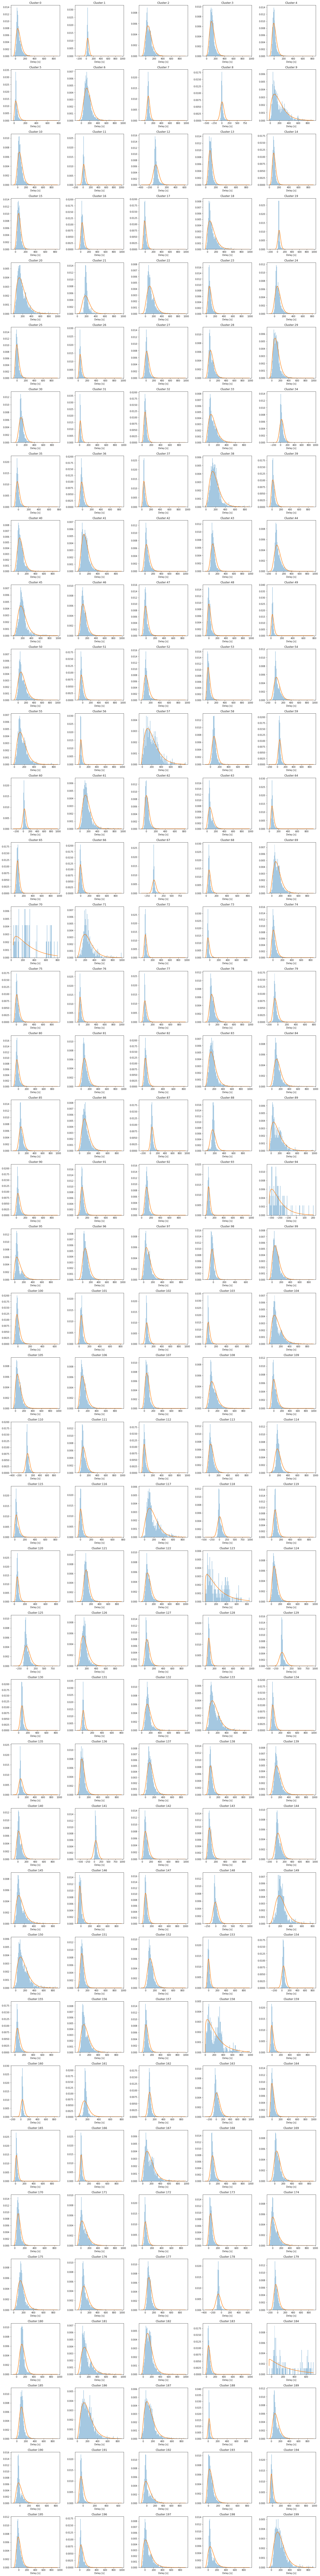

In [187]:
gammas = {} # map cluster label -> gamma distribution

# #clusters (K) = 200 = 5*40
ncols = 5
nrows = 40
fig, axs = plt.subplots(nrows, ncols, figsize=(4*ncols, 4*nrows))

axs = np.ndenumerate(axs)

# i = 0
for cl, delays in cluster_delays.items():
#     if i>=10:
#         break
#     i+=1
    
    _, ax = next(axs)
    
    sns.set(color_codes=True)

    # plot histogram
    ax.set(xlabel='Delay [s]')
    sns.distplot(delays, bins=100, kde=False, ax=ax, norm_hist=True)
    
    # fit the gamma on the delays of the cluster
    if cl in [70, 94]:
        # these two clusters are best fitted in this way
        gammas[cl] = gamma(
            *gamma.fit(
                delays,
                loc=delays.min()
            )
        )
    else:
        gammas[cl] = gamma(
            *gamma.fit(
                delays,
                floc=delays.min()-1e-10)
        )

    # plot the gamma's pdf on the same plot
    x = np.linspace(delays.min(),delays.max(),1000)
    ax.plot(x, gammas[cl].pdf(x), label='Gamma distribution')
    ax.set_title("Cluster:" + str(cl))
    
plt.tight_layout()

We can see that the **gammas fit reasonibly well** the delays of the clusters! Let's see the probabilities of the delays being **lower than 5 minutes** (300 seconds):

In [188]:
pd.Series([gamma.cdf(300) for _, gamma in gammas.items()]).describe()

count    200.000000
mean       0.969036
std        0.067593
min        0.594040
25%        0.976132
50%        0.998879
75%        0.999989
max        1.000000
dtype: float64

Most of the probabilities are high, it means that there is often a high probability that the transports do less than 5 minutes of delay and we can safely take a connection whose departure is scheduled 5 minutes after our arrival.

- add a new column to the `schedule` to **store**, for each edge, **the distribution** of its cluster. Then, store the obtained `schedule`.

In [189]:
for c_id in clusters_labels:
    schedule.loc[schedule["label"] == c_id, "distribution"] = gammas[c_id]
schedule.head(2)

,trip_id,dep_node,arr_node,dep_day,arr_day,dep_time,arr_time,delays,num_delays,label,distribution,walking_time
0,85:11:18388:001,Dietlikon,Stettbach,0,0,23:14:00,23:17:00,"(-2, 62, 257, 194, 233, 75, -20, -8, -5, 34, 4...",33.0,54.0,<scipy.stats._distn_infrastructure.rv_frozen o...,NaT
1,85:11:18388:001,Stettbach,Zürich Stadelhofen,0,0,23:18:00,23:22:00,"(1, 13, 219, 187, 203, 44, 13, 1, 12, 148, 14,...",33.0,196.0,<scipy.stats._distn_infrastructure.rv_frozen o...,NaT


In [192]:
schedule.to_pickle("data/schedule_clustered.pkl")

## Final clean 
Add/remove the columns to obtain the final DataFrame that will be used by the `Planner`.

In [6]:
schedule = pd.read_pickle("data/schedule_clustered.pkl")

# keep only columns used by the algorithm
schedule = schedule[["trip_id", "dep_node", "arr_node", "dep_day", "arr_day", "dep_time", "arr_time", "distribution", "walking_time"]]

# the prob column will store the probability of taking the edge, i.e. of taking a mean of transport at a specific time
schedule["prob"] = np.NaN
# the label column indicates the status of the edge
schedule["label"] = Status.Unvisited
# the prev_edge column indicates the previous edge taken on a path and will allow to reconstruct the whole path
schedule["prev_edge"] = np.NaN

schedule.head()

,trip_id,dep_node,arr_node,dep_day,arr_day,dep_time,arr_time,distribution,walking_time,prob,label,prev_edge
0,85:11:18388:001,Dietlikon,Stettbach,0,0,23:14:00,23:17:00,<scipy.stats._distn_infrastructure.rv_frozen o...,NaT,NaN,Unvisited,NaN
1,85:11:18388:001,Stettbach,Zürich Stadelhofen,0,0,23:18:00,23:22:00,<scipy.stats._distn_infrastructure.rv_frozen o...,NaT,NaN,Unvisited,NaN
2,85:11:18388:001,Zürich Stadelhofen,Zürich HB,0,0,23:23:00,23:26:00,<scipy.stats._distn_infrastructure.rv_frozen o...,NaT,NaN,Unvisited,NaN
3,85:11:18388:001,Zürich HB,Zürich Hardbrücke,0,0,23:29:00,23:31:00,<scipy.stats._distn_infrastructure.rv_frozen o...,NaT,NaN,Unvisited,NaN
4,85:11:18388:001,Zürich Hardbrücke,Zürich Altstetten,0,0,23:31:00,23:35:00,<scipy.stats._distn_infrastructure.rv_frozen o...,NaT,NaN,Unvisited,NaN


In [12]:
# then also estract the paths of the trips and add a column indicating the id of the path
def extract_path(x):
    first_node = x.dep_node[0]
    middle_nodes = x.dep_node[1:]
    last_node = x.arr_node[-1]
                  
    if first_node in middle_nodes:
        idx = middle_nodes.index(first_node)
        middle_nodes = middle_nodes[:idx]
    
    
    path = [first_node] + middle_nodes + [last_node]
    return path

# collect the path of each trip_id
paths = (schedule[schedule.trip_id!="0000"]
         .sort_values(["dep_day", "dep_time"])
         .groupby("trip_id")[["dep_node", "arr_node"]]
         .agg(lambda x: list(x))
         .apply(extract_path, axis=1)
        )

paths = pd.DataFrame(
    data={
        "trip_id": paths.index,
        "directed_path": paths.values        
    }
)

# give the same order to the nodes of the paths, i.e. A->B->C and C->B->A should be indistinguishable
def undirect(x):
    if x[0] > x[-1]:
        return x[::-1]
    return x

paths["path"] = paths.directed_path.apply(undirect)
paths.path = paths.path.astype("str")
paths.directed_path = paths.directed_path.astype("str")

print("Snapshot of the #trips that share the same path:")
display(paths.groupby("path").count().head())

# map each path to an id
paths["direct_path_id"] = pd.factorize(paths.path)[0]
paths["path_id"] = pd.factorize(paths.path)[0]
paths.set_index("trip_id", inplace=True)
print("Snapshot of the trip ids and repsective paths:")
pd.set_option('display.max_colwidth', -1)
display(paths.head(10))
pd.set_option('display.max_colwidth', 50)

# join the new information to the schedule
schedule = schedule.merge(paths.reset_index()[["trip_id", "direct_path_id"]], how="left").rename(columns={"direct_path_id":"path_id"})

Snapshot of the #trips that share the same path:


,directed_path,trip_id
path,,
"['Adliswil', 'Sood-Oberleimbach', 'Zürich Leimbach', 'Zürich Manegg', 'Zürich Brunau', 'Zürich Saalsporthalle', 'Zürich Giesshübel', 'Zürich Selnau', 'Zürich HB SZU']",1,1
"['Bonstetten-Wettswil', 'Stettbach', 'Zürich Altstetten', 'Zürich Hardbrücke', 'Zürich HB', 'Zürich Stadelhofen']",2,2
"['Bonstetten-Wettswil', 'Zürich Altstetten', 'Zürich HB', 'Zürich Oerlikon', 'Wallisellen', 'Dübendorf']",60,60
"['Bonstetten-Wettswil', 'Zürich Altstetten', 'Zürich Hardbrücke', 'Zürich HB', 'Zürich Stadelhofen']",80,80
"['Bonstetten-Wettswil', 'Zürich Altstetten', 'Zürich Hardbrücke', 'Zürich HB']",3,3


Snapshot of the trip ids and repsective paths:


,directed_path,path,direct_path_id,path_id
trip_id,,,,
85:11:13710:001,"['Zürich HB', 'Zürich Hardbrücke', 'Zürich Altstetten']","['Zürich Altstetten', 'Zürich Hardbrücke', 'Zürich HB']",0,0
85:11:13711:001,"['Zürich HB', 'Zürich Stadelhofen', 'Stettbach', 'Dietlikon']","['Dietlikon', 'Stettbach', 'Zürich Stadelhofen', 'Zürich HB']",1,1
85:11:13712:001,"['Dietlikon', 'Stettbach', 'Zürich Stadelhofen', 'Zürich HB', 'Zürich Hardbrücke', 'Zürich Altstetten']","['Dietlikon', 'Stettbach', 'Zürich Stadelhofen', 'Zürich HB', 'Zürich Hardbrücke', 'Zürich Altstetten']",2,2
85:11:13713:001,"['Zürich Altstetten', 'Zürich Hardbrücke', 'Zürich HB', 'Zürich Stadelhofen', 'Stettbach', 'Dietlikon']","['Dietlikon', 'Stettbach', 'Zürich Stadelhofen', 'Zürich HB', 'Zürich Hardbrücke', 'Zürich Altstetten']",2,2
85:11:13714:001,"['Dietlikon', 'Stettbach', 'Zürich Stadelhofen', 'Zürich HB', 'Zürich Hardbrücke', 'Zürich Altstetten']","['Dietlikon', 'Stettbach', 'Zürich Stadelhofen', 'Zürich HB', 'Zürich Hardbrücke', 'Zürich Altstetten']",2,2
85:11:13715:001,"['Zürich Altstetten', 'Zürich Hardbrücke', 'Zürich HB', 'Zürich Stadelhofen', 'Stettbach', 'Dietlikon']","['Dietlikon', 'Stettbach', 'Zürich Stadelhofen', 'Zürich HB', 'Zürich Hardbrücke', 'Zürich Altstetten']",2,2
85:11:13716:001,"['Dietlikon', 'Stettbach', 'Zürich Stadelhofen', 'Zürich HB', 'Zürich Hardbrücke', 'Zürich Altstetten']","['Dietlikon', 'Stettbach', 'Zürich Stadelhofen', 'Zürich HB', 'Zürich Hardbrücke', 'Zürich Altstetten']",2,2
85:11:13717:001,"['Zürich Altstetten', 'Zürich Hardbrücke', 'Zürich HB', 'Zürich Stadelhofen', 'Stettbach', 'Dietlikon']","['Dietlikon', 'Stettbach', 'Zürich Stadelhofen', 'Zürich HB', 'Zürich Hardbrücke', 'Zürich Altstetten']",2,2
85:11:13750:001,"['Zürich HB', 'Zürich Hardbrücke', 'Zürich Altstetten', 'Bonstetten-Wettswil']","['Bonstetten-Wettswil', 'Zürich Altstetten', 'Zürich Hardbrücke', 'Zürich HB']",3,3


In [13]:
# store both the schedule and the path of each trip
schedule.to_pickle("data/schedule_clean.pkl")
paths.to_pickle("data/trip_paths.pkl")

### Journey Planner 

hypotheses:

    i) given the arcs A->B, if ta_dep < tb_dep => ta_arr < tb_arr (before you depart before you arrive)
    ii) delays distribute with lognorm


simplifications:
    - the number of changes is not taken into account (one would prefer also to take do few stops)


## Test Planner

### Tests on toy schedule

- `init_edges`

In [30]:
# direct search
time = pd.Timedelta("10:00:00")
planner = Planner(toy_schedule(), reverse=False)
planner.select_subset_edges(time)

sol = [0, 3, 6]
stop_name = "node1"

ids = planner.init_edges(stop_name, time)
assert set(sol) == set(ids)

print("OK!")
# planner.edges.loc[sol]

OK!


In [36]:
# reverse search
time = pd.Timedelta("24:00:00")
planner = Planner(toy_schedule(), reverse=True)
planner.select_subset_edges(time)

sol = [2, 5, 7]
stop_name = "node5"
time = pd.Timedelta("10:45:00")

ids = planner.init_edges(stop_name, time)
assert set(sol) == set(ids)

print("OK!")
# planner.edges.loc[sol]

OK!


- `expand_edge`

In [37]:
# direct search
time = pd.Timedelta("10:00:00")
planner = Planner(toy_schedule(), reverse=False)
planner.select_subset_edges(time)
planner.edges.dep_node = "node2" # just to increase the possible choices

planner.edges.loc[0, "prob"] = 1
ids = planner.expand_edge(0, 0.4) # expand the edge with id 1

sol = [1, 5, 7]
assert set(sol) == set(ids)

print("OK!")
# planner.edges

OK!


In [38]:
# reverse search
time = pd.Timedelta("24:00:00")
planner = Planner(toy_schedule(), reverse=True)
planner.select_subset_edges(time)
planner.edges.arr_node = "node4" # just to increase the possible choices

planner.edges.loc[5, "prob"] = 1
ids = planner.expand_edge(5, 0.4) # expand the edge with id 4

sol = [0, 4, 8]
assert set(sol) == set(ids)

print("OK!")
# planner.edges

OK!


- `best_node`

In [41]:
# direct search
time = pd.Timedelta("10:00:00")
planner = Planner(toy_schedule(), reverse=False)
planner.select_subset_edges(time)
visited = np.array([0, 3, 5, 8])

planner.edges.loc[visited, "label"] = Status.Visited

best = planner.best_node(visited)
sol = 3
assert sol == best

print("OK!")
# planner.edges[planner.edges.label == Status.Visited]

OK!


In [40]:
# reverse search
time = pd.Timedelta("24:00:00")
planner = Planner(toy_schedule(), reverse=True)
planner.select_subset_edges(time)
visited = np.array([0, 3, 5, 8])

planner.edges.loc[visited, "label"] = Status.Visited

best = planner.best_node(visited)
sol = 5
assert sol == best

print("OK!")
# planner.edges[planner.edges.label == Status.Visited]

OK!


- `done`

In [43]:
# direct search
time = pd.Timedelta("10:00:00")
planner = Planner(toy_schedule(), reverse=False)
planner.select_subset_edges(time)

assert planner.done(2, "node5")
assert not planner.done(2, "node1")
assert planner.done(6, "node3")
assert not planner.done(8, "node1")

# reverse search
planner.reverse = True
assert planner.done(2, "node4")
assert not planner.done(2, "node1")
assert planner.done(6, "node1")
assert not planner.done(8, "node4")

print("OK!")
# planner.edges

OK!


- `compute_plan`

In [60]:
schedule = toy_schedule()
# schedule = schedule[~schedule.index.isin([8])].copy() # remove some edges

departure_node = "node1"
arrival_node = "node5"

# list of tuple (treshold, edges to drop, solution)
tresh_sol = [
    (0.00, [], [6, 8, 5]),
    (0.99, [], [0, 1, 2]),
    (0.00, [8], [3, 4, 5]),
    (0.85, [1], [6, 8, 2]),
    (0.8, [1, 2], [6, 8, 5]),
    (0.9, [1, 2], [6, 7]),
]

# run direct and reverse algorithm
direct_time = pd.Timedelta("10:00:00")
for treshold, drop_ids, sol in tresh_sol:
#     print("----------------")
    # drop edges
    edges = schedule[~schedule.index.isin(drop_ids)]
    
    # direct search
    planner = Planner(edges.copy(), reverse=False)
    path = planner.compute_plan(departure_node, arrival_node, direct_time, treshold)
    assert sol==path
    
#     print("---------asd-------")
    # reverse search
    planner = Planner(edges.copy(), reverse=True)
    time = edges.loc[sol[-1], "arr_time"] # take the time of the last one of the solution, so that you should get the solution as output
    path = planner.compute_plan(departure_node, arrival_node, time, treshold)
    assert sol==path

print("OK!")
# planner.edges

OK!


### Tests on real schedule

In [1]:
from scipy.stats import gamma, lognorm
import pandas as pd
import numpy as np

import matplotlib.pylab as plt
import seaborn as sns

from pyscripts.test_utils import toy_schedule
from pyscripts.planner import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [ ]:
schedule = pd.read_pickle("data/schedule_clean.pkl")

# time = pd.Timedelta("4 day 23:59:00")
time = pd.Timedelta("2 day 13:9:00")
start_node = 'Zürich HB'

pl = Planner(schedule, reverse=False)
pl.select_subset_edges(time)
a, b = pl.init_edges(start_node, time)
# print(len(a), len(b))
# pl.edges.loc[pl.walk_ids, "arr_time"] += pd.Timedelta("00:10:00")
best_id = pl.pop_best_edge(a.copy(), b.copy())

display(pl.edges.loc[[best_id]])

ids_tr, ids_walk = pl.expand_edge(best_id, 0.8)

%timeit pl = Planner(schedule, reverse=True)
%timeit pl.select_subset_edges(time)
%timeit a, b = pl.init_edges(start_node, time)
%timeit best_id = pl.pop_best_edge(a.copy(), b.copy())
%timeit ids = pl.expand_edge(best_id, 0.8)

# display(pl.edges.loc[[best_id]])
pl.edges.loc[sorted(ids_tr) + ids_walk]#.head()

In [233]:
all_trips = schedule.trip_id.unique()
asd = pd.Series(index=all_trips, data=False)

In [47]:
schedule = pd.read_pickle("data/schedule_clean.pkl")
walk = schedule[schedule.trip_id == "0000"]
transp = schedule[schedule.trip_id != "0000"]
valid_stations = np.unique(np.append(transp.arr_node.values, transp.dep_node.values))

print(valid_stations.shape)
valid_waks = walk[walk.arr_node.isin(valid_stations) & walk.arr_node.isin(valid_stations)]
print(valid_waks.shape)
valid_waks

(46,)
(82, 13)


,trip_id,dep_node,arr_node,dep_day,arr_day,dep_time,arr_time,distribution,walking_time,prob,label,prev_edge,path_id
53104,0000,Zürich HB,Zürich HB SZU,NaN,NaN,NaT,NaT,NaN,00:02:20,NaN,Unvisited,NaN,NaN
53138,0000,Zürich Stadelhofen FB,Zürich Stadelhofen,NaN,NaN,NaT,NaT,NaN,00:00:46,NaN,Unvisited,NaN,NaN
53152,0000,Zürich HB SZU,Zürich HB,NaN,NaN,NaT,NaT,NaN,00:02:20,NaN,Unvisited,NaN,NaN
53198,0000,Zürich Landesmuseum (See),Zürich HB,NaN,NaN,NaT,NaT,NaN,00:03:04,NaN,Unvisited,NaN,NaN
53220,0000,Zollikon (See),Zollikon,NaN,NaN,NaT,NaT,NaN,00:04:45,NaN,Unvisited,NaN,NaN
53242,0000,"Thalwil, Zentrum",Thalwil,NaN,NaN,NaT,NaT,NaN,00:02:00,NaN,Unvisited,NaN,NaN
53245,0000,"Thalwil, Bahnhof",Thalwil,NaN,NaN,NaT,NaT,NaN,00:00:41,NaN,Unvisited,NaN,NaN
53248,0000,"Zürich Flughafen, Bahnhof",Zürich Flughafen,NaN,NaN,NaT,NaT,NaN,00:02:29,NaN,Unvisited,NaN,NaN
53249,0000,"Zürich Flughafen, Werft",Kloten Balsberg,NaN,NaN,NaT,NaT,NaN,00:04:34,NaN,Unvisited,NaN,NaN
53250,0000,"Kloten, Balsberg Hardacher",Kloten Balsberg,NaN,NaN,NaT,NaT,NaN,00:04:10,NaN,Unvisited,NaN,NaN


In [39]:
schedule = pd.read_pickle("data/schedule_clean.pkl")
pairwise_distances = pd.read_pickle("data/pairwise_distance.pkl")
# pairwise_distances = None

pl = Planner(schedule, pairwise_distances=pairwise_distances, reverse=False)

# working:
dep, arr = 'Stettbach', 'Rümlang'
# dep, arr = 'Zürich HB', 'Zürich Stadelhofen'
# dep, arr = 'Zürich HB', "Dübendorf"
# dep, arr = 'Dietlikon', 'Regensdorf-Watt'
# dep, arr = 'Sihlau', 'Zürich HB SZU'
# dep, arr = 'Zürich HB SZU', 'Sihlau'
# dep, arr = 'Zürich HB SZU', 'Zürich HB' 
# dep, arr = 'Zürich HB', 'Adliswil'
# dep, arr = 'Sihlau', 'Zürich HB' 
# dep, arr = 'Zürich H', 'Waldegg, Post'
# dep = 'Adliswil, Eichenweg', 'Zürich HB'
# dep, arr = 'Zürich Altstetten, Bahnhof N', 'Zürich HB'
# dep, arr = "Zürich Landesmuseum (See)", 'Adliswil'
# dep, arr = 'Zürich Binz', 'Zürich Enge'

time = pd.Timedelta("1 day 13:45:00")
treshold = 0.25

path = pl.compute_plan(dep, arr, time, treshold)
# %timeit pl.compute_plan(dep, arr, time, treshold) # 7.42s 8.4s wrt 11.3s (trip pruning)

# print("Path:", last_id)
if path is not None:
    display(pl.edges.loc[path])

,trip_id,dep_node,arr_node,dep_day,arr_day,dep_time,arr_time,distribution,walking_time,prob,label,prev_edge,path_id,nice_direction
21,85:11:18350:001,Stettbach,Zürich Stadelhofen,1,1,13:48:00,13:52:00,<scipy.stats._distn_infrastructure.rv_frozen o...,NaT,1.000000,Expanded,NaN,2,False
49,85:11:18350:001,Zürich Stadelhofen,Zürich HB,1,1,13:53:00,13:56:00,<scipy.stats._distn_infrastructure.rv_frozen o...,NaT,1.000000,Expanded,21.0,2,True
122,85:11:2648:001,Zürich HB,Zürich Oerlikon,1,1,14:01:00,14:07:00,<scipy.stats._distn_infrastructure.rv_frozen o...,NaT,0.999983,Expanded,49.0,102,True
4405,85:11:19518:001,Zürich Oerlikon,Glattbrugg,2,2,06:00:00,06:02:00,<scipy.stats._distn_infrastructure.rv_frozen o...,NaT,0.999983,Expanded,122.0,63,True
4423,85:11:19518:001,Glattbrugg,Rümlang,2,2,06:03:00,06:05:00,<scipy.stats._distn_infrastructure.rv_frozen o...,NaT,0.999983,Visited,4405.0,63,True


In [ ]:
paths = pd.read_pickle("data/trip_paths.pkl")
# pd.set_option('display.max_colwidth', -1)
# display(pd.DataFrame(paths[["path", "path_id"]].drop_duplicates()))
# pd.set_option('display.max_colwidth', 50)

In [40]:
schedule = pd.read_pickle("data/schedule_clean.pkl")
pairwise_distances = pd.read_pickle("data/pairwise_distance.pkl")

# working:
dep = 'Stettbach'
dep = 'Rümlang'
dep = 'Zürich Stadelhofen'
dep = 'Dübendorf'
dep = 'Regensdorf-Watt'
dep = 'Dietlikon'
dep = 'Sihlau'
dep = 'Zürich HB SZU'
dep = 'Adliswil'
dep = 'Zürich HB' 

time = pd.Timedelta("0 day 13:00:00")
max_time = pd.Timedelta("0 day 15:00:00")
treshold = 0.75

pl = Planner(schedule, pairwise_distances=pairwise_distances, reverse=False)
# %timeit reached = pl.compute_isocrone(dep, time, max_time, treshold) #15.5s (1 wrong edge), 20.9s (2 wrong edges)
reached = pl.compute_isocrone(dep, time, max_time, treshold) #15.5 s

# pl = Planner(schedule, pairwise_distances=None, reverse=False)
# %timeit reached = pl.compute_isocrone(dep, time, max_time, treshold) #22.5 s

# reached = pl.compute_isocrone(dep, time, max_time, treshold)

reached

,arr_day,arr_time
arr_node,,
Zürich HB,0.0,13:00:00
Zürich HB SZU,0.0,13:02:20
"Zürich, Bahnhofplatz/HB",0.0,13:02:20
"Zürich, Bahnhofstrasse/HB",0.0,13:02:59
Zürich Hardbrücke,0.0,13:03:00
Zürich Landesmuseum (See),0.0,13:03:04
"Zürich, Bahnhofquai/HB",0.0,13:03:05
"Zürich Hardbrücke, Bahnhof",0.0,13:03:29
Zürich Stadelhofen,0.0,13:05:00


In [ ]:
pd.set_option('max_rows', 1000)
pl.edges.loc[pl.edges.label==Status.Expanded]#, "arr_node"]
# pd.set_option('max_rows', 100)